### 先训练一个基础的XGBoost模型，然后使用网格搜索调参。

In [7]:
import pandas as pd # type: ignore
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import xgboost
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# 显示所有列
pd.set_option('display.max_columns', None)
# # 显示所有行
pd.set_option('display.max_rows', None) 
df = pd.read_csv('..\Data\data1.csv') # 请确保文件路径正确
features = df.columns.tolist() 
# 除去最后一列
features = features[:-1]
features

['X1',
 'X2',
 'X3',
 'X4',
 'X5',
 'X6',
 'X7',
 'X8',
 'X9',
 'X10',
 'X11',
 'X12',
 'X13',
 'X14',
 'X15',
 'X16',
 'X17',
 'X18',
 'X19',
 'X20',
 'X21',
 'X22',
 'X23',
 'X24']

In [8]:

import pandas as pd
#1. 加载数据
df = pd.read_csv('..\Data\data1.csv') # 请确保文件路径正确

#2. 数据预处理
# 剔除掉X4,X8,X13
X = df.drop(['Y(1=default, 0=non-default)'], axis=1) # 假设'Target'是目标变量
# X = df[important_features]
y = df['Y(1=default, 0=non-default)']

# #处理类别变量
# X = pd.get_dummies(X, drop_first=True)

# #3. 数据标准化
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

#4. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ## 在xgboost的基础上添加SMOTE对少数样本进行过采样，以解决正负样本不均衡问题
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)


#5. 训练XGBoost模型
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

#6. 评估模型性能
y_pred_proba = xgb.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc}")

AUC: 0.8235364827503306


使用非线性变换来映射违约概率到分数。一个常用的方法是使用Beta分布的累积分布函数（CDF），因为Beta分布可以灵活地调整形状参数来控制分布的偏斜和峰度。

然而，为了简化，我们可以采用一个更简单的非线性变换，比如平方根或者对数变换后再进行线性缩放和平移，以使得分数分布更加均匀。以下是一个使用平方根变换并线性缩放的示例：

In [9]:
from scipy.stats import beta
# 假设X是特征，y是标签（0或1）
dtrain = xgboost.DMatrix(X_train, label=y_train)
# 初始化一个空的DMatrix，稍后将用于存储所有样本的特征
dall = xgboost.DMatrix(X)

params = {
    'objective': 'binary:logistic',  # 二元分类
    'eval_metric': 'auc',
    # 其他参数...
}

model = xgboost.train(params, dtrain, num_boost_round=100)
dtest = xgboost.DMatrix(X_test)
# 这将返回违约的概率
# probabilities = model.predict(dtest)
probabilities = model.predict(dall)
def probability_to_score(prob, base_score=850, min_score=300, alpha=0.35, bet=0.5):
    # 确保prob在(0, 1)范围内
    prob = np.clip(prob, 1e-15, 1-1e-15)
    
    # 使用Beta分布的CDF计算得分
    # 注意：这里我们翻转了prob，因为Beta CDF在prob接近0时值接近0，在prob接近1时值接近1
    # 而我们希望prob低时分数高，prob高时分数低
    cdf_value = 1 - beta.cdf(prob, alpha, bet)
    
    # 将CDF值映射到分数范围
    score_range = base_score - min_score
    score_raw = cdf_value * score_range
    
    # 加上最小分数作为偏移
    score = min_score + score_raw
    
    # 确保分数在[min_score, base_score]范围内
    score = np.clip(score, min_score, base_score)
    
    return score

credit_scores = [probability_to_score(p) for p in probabilities]
credit_scores

[792.5730654680168,
 330.6750046034459,
 824.8367600051117,
 711.5100495903448,
 357.8372027239807,
 711.9745462706387,
 811.7142319482916,
 684.8966678405815,
 803.3526387362577,
 347.2292855017633,
 499.01407874130393,
 347.59842474535776,
 725.051835893941,
 388.7131446895269,
 571.6430774418205,
 384.432421063508,
 808.919174127122,
 677.5869157088573,
 318.7238079369727,
 792.6321169254413,
 823.8904015193416,
 762.5396074359269,
 776.0096427077794,
 753.7893248013015,
 800.4052128155618,
 681.152388944321,
 716.2529190359226,
 700.0925321438403,
 781.5460555647869,
 320.00679107505664,
 688.7389672261382,
 598.8778435057546,
 625.3186691862459,
 786.0537109832553,
 752.193464903363,
 333.9351102165405,
 669.6750877171878,
 375.5065674343421,
 650.9146903570945,
 690.1934676982485,
 738.6292247040935,
 720.2535416144985,
 683.6210545967228,
 740.9900277461547,
 485.5329693521993,
 752.537922479429,
 762.6047788685607,
 746.4547489682276,
 796.4532580501686,
 707.6720789212628,
 69

### 数据观察
#### x1,x3,x5,x6,x7,x8,x9,x11,x12是非二值离散型特征，且可能存在有序关系，进行标签编码
#### x2,x4,x10是连续型特征，且可能与年龄相关，依据最值进行分段后，进行标签编码
#### x13,x14,x15为1或2，转化为0/1二值特征；x16-24是二值特征，直接使用

## 添加SMOTE对少数样本进行过采样，以解决正负样本不均衡问题

### 基于训练后模型评估的结果构建一个评分体系

In [10]:
# 7. 构建评分卡
def create_scorecard(model, feature_names, base_score=600, pdo=20, odds=50):
    # 获取特征重要性
    feature_importance = model.feature_importances_
    
    # 计算评分卡参数
    factor = pdo / np.log(2)
    offset = base_score - factor * np.log(odds)
    
    # 计算每个特征的得分
    scores = {}
    for feature, importance in zip(feature_names, feature_importance):
        score = round(offset + factor * np.log(importance + 1e-6))  # 加一个小数以避免log(0)
        scores[feature] = score
    
    return scores

# 创建评分卡
scorecard = create_scorecard(xgb, X.columns)

# 8. 计算信用得分
# 修改后的 calculate_credit_score 函数
def calculate_credit_score(X, scorecard):
    scores = np.zeros(X.shape[0])
    for feature, score in scorecard.items():
        if feature in X.columns:
            scores += X[feature].values * score
    return scores


# 在计算信用得分时，使用原始的 X（未标准化的数据）
# credit_scores = calculate_credit_score(X, scorecard)

# 9. 将信用得分添加到原始数据框中
df['Credit_Score'] = credit_scores


$$ \text{score}_{\text{feature}_i} = \text{offset} + \text{factor} \cdot \log(\text{importance}_i + \epsilon) $$

### 评分卡可视化（这个东西没必要）

d:\ProgramData\anaconda3\envs\pyTorchgpuEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


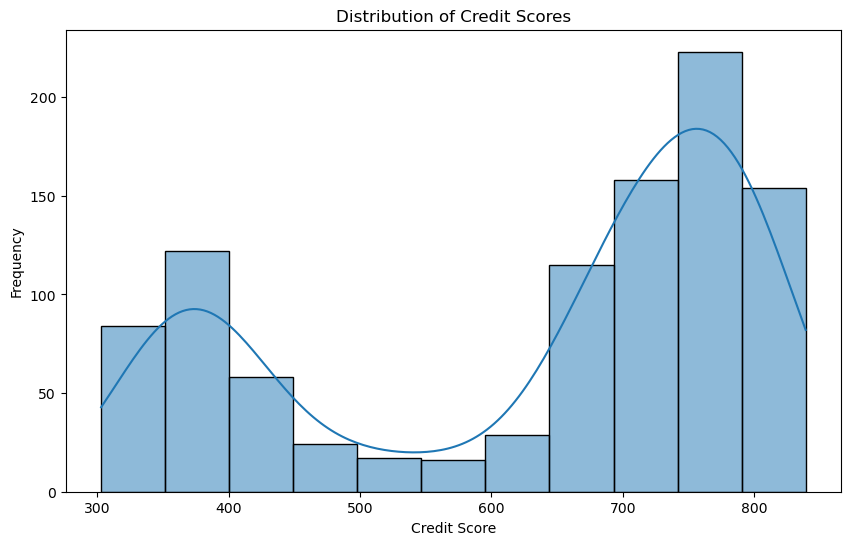

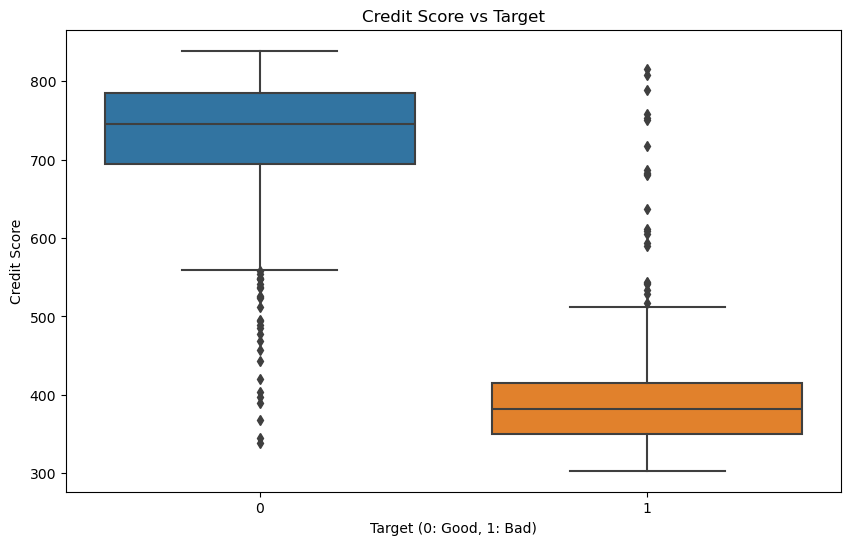

In [11]:

# 10. 可视化评分卡
# plt.figure(figsize=(12, 8))
# sns.barplot(x=list(scorecard.values()), y=list(scorecard.keys()))
# plt.title('Credit Scorecard')
# plt.xlabel('Score')
# plt.ylabel('Feature')
# plt.tight_layout()
# # 保存图片
# plt.savefig('../Data/Q2_credit_scorecard.png')
# plt.show()

# 11. 可视化信用得分分布
plt.figure(figsize=(10, 6))
sns.histplot(df['Credit_Score'], kde=True)
plt.title('Distribution of Credit Scores')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
# 保存图片
plt.savefig('../Data/Q2_credit_score_distribution.png')
plt.show()

# 12. 信用得分与目标变量的关系
plt.figure(figsize=(10, 6))
sns.boxplot(x='Y(1=default, 0=non-default)', y='Credit_Score', data=df)
plt.title('Credit Score vs Target')
plt.xlabel('Target (0: Good, 1: Bad)')
plt.ylabel('Credit Score')
# 保存图片
plt.savefig('../Data/Q2_credit_score_vs_target.png')
plt.show()



### 得分保存到一个csv文件中方便后续问题直接调用

In [12]:
# 13. 打印信用得分的描述性统计
print("\nCredit Score Statistics:")
print(df['Credit_Score'].describe())

# 14. 保存结果
df.to_csv('../Data/Q2_german_credit_data_with_scores.csv', index=False)
print("\nResults saved to 'german_credit_data_with_scores.csv'")

# 15. 打印评分卡
print("\nScorecard:")
for feature, score in sorted(scorecard.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {score}")


Credit Score Statistics:
count    1000.000000
mean      632.617477
std       171.032422
min       303.127718
25%       430.793292
50%       707.657267
75%       768.364472
max       838.960751
Name: Credit_Score, dtype: float64

Results saved to 'german_credit_data_with_scores.csv'

Scorecard:
X1: 416
X22: 409
X18: 408
X16: 403
X17: 402
X3: 401
X23: 400
X11: 398
X2: 396
X13: 395
X5: 394
X4: 393
X21: 392
X6: 390
X9: 390
X14: 390
X15: 390
X20: 390
X7: 388
X10: 387
X8: 384
X12: 382
X24: 382
X19: 371
